In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
BATCH_SIZE = 25
DATA_DIR = "/Users/omgoswami/Downloads/split/Lymphoma"

# Define the directories for each set
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SIZE = 256
MAX_EPOCHS = 25
class_names = ["lymph_cll","lymph_fl","lymph_mcl"]
class_details = ["lymph_cll","lymph_fl","lymph_mcl"]

# Use the appropriate directories for each set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45
)

Found 12750 files belonging to 3 classes.
Found 2250 files belonging to 3 classes.
Found 2250 files belonging to 3 classes.


In [3]:
def print_image_count(dataset, dataset_name):
    num_images = len(dataset) * BATCH_SIZE
    print(f"Number of images in {dataset_name} dataset: {num_images}")

print_image_count(train_ds, "train")
print_image_count(validation_ds, "validation")
print_image_count(test_ds, "test")

Number of images in train dataset: 12750
Number of images in validation dataset: 2250
Number of images in test dataset: 2250


In [4]:
pretrained_efficientnet_base = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False, weights="imagenet", pooling="avg",
)
pretrained_efficientnet_base.trainable = False

efficientnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    pretrained_efficientnet_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 10,980,658
Trainable params: 197,123
Non-trainable params: 10,783,535
_________________________________________________________________


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

# Cache and prefetch datasets
train_ds = train_ds.cache(".cached-data").prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache(".cached-data-test").prefetch(buffer_size=AUTOTUNE)

efficientnet_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    mode="auto",
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=5,
    min_lr=0.001
)
steps_per_epoch = len(train_ds)
train_ds = train_ds.repeat()
history = efficientnet_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=MAX_EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=steps_per_epoch
)

Epoch 1/25


2024-01-21 16:19:34.572431: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-21 16:19:34.741948: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_2.


510/510 [==============================] - 275s 521ms/step - loss: 0.2618 - accuracy: 0.8998 - val_loss: 2.2079 - val_accuracy: 0.3569 - lr: 0.0010
Epoch 2/25
510/510 [==============================] - 297s 583ms/step - loss: 0.1467 - accuracy: 0.9450 - val_loss: 2.3646 - val_accuracy: 0.3533 - lr: 0.0010
Epoch 3/25
510/510 [==============================] - 307s 602ms/step - loss: 0.1089 - accuracy: 0.9597 - val_loss: 2.6374 - val_accuracy: 0.3516 - lr: 0.0010
Epoch 4/25
510/510 [==============================] - 296s 581ms/step - loss: 0.0944 - accuracy: 0.9636 - val_loss: 3.0686 - val_accuracy: 0.3489 - lr: 0.0010
Epoch 5/25
510/510 [==============================] - 319s 626ms/step - loss: 0.0925 - accuracy: 0.9657 - val_loss: 3.3179 - val_accuracy: 0.3413 - lr: 0.0010
Epoch 6/25
510/510 [==============================] - 308s 604ms/step - loss: 0.0847 - accuracy: 0.9690 - val_loss: 3.7213 - val_accuracy: 0.3733 - lr: 0.0010


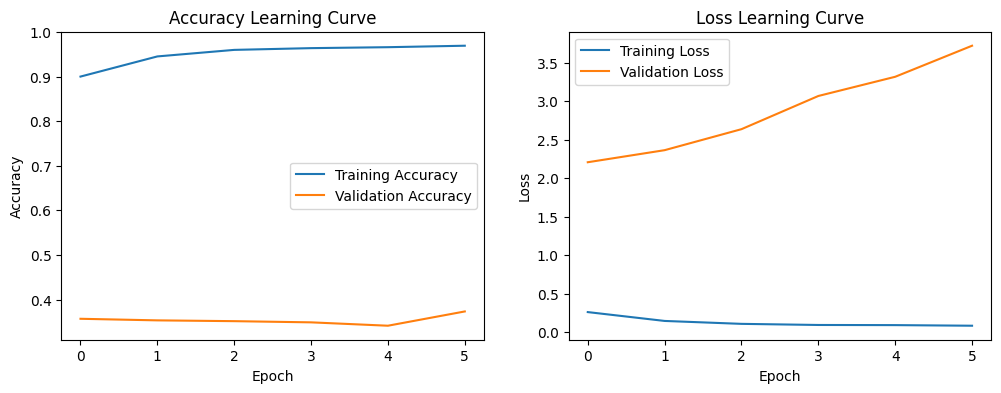

In [6]:
# Plot training history
performance_df = pd.DataFrame(history.history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy
axes[0].plot(performance_df['accuracy'], label='Training Accuracy')
axes[0].plot(performance_df['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy Learning Curve')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot loss
axes[1].plot(performance_df['loss'], label='Training Loss')
axes[1].plot(performance_df['val_loss'], label='Validation Loss')
axes[1].set_title('Loss Learning Curve')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()

In [7]:
from sklearn.metrics import confusion_matrix, classification_report

test_loss, test_accuracy = efficientnet_model.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

90/90 [==============================] - 46s 503ms/step - loss: 0.1747 - accuracy: 0.9369
Test Accuracy: 93.69%


In [8]:
y_pred = efficientnet_model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

conf_mat = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_mat)

class_report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(class_report)

90/90 [==============================] - 46s 488ms/step
Confusion Matrix:
[[723  27   0]
 [ 14 728   8]
 [ 19  74 657]]
Classification Report:
              precision    recall  f1-score   support

   lymph_cll       0.96      0.96      0.96       750
    lymph_fl       0.88      0.97      0.92       750
   lymph_mcl       0.99      0.88      0.93       750

    accuracy                           0.94      2250
   macro avg       0.94      0.94      0.94      2250
weighted avg       0.94      0.94      0.94      2250



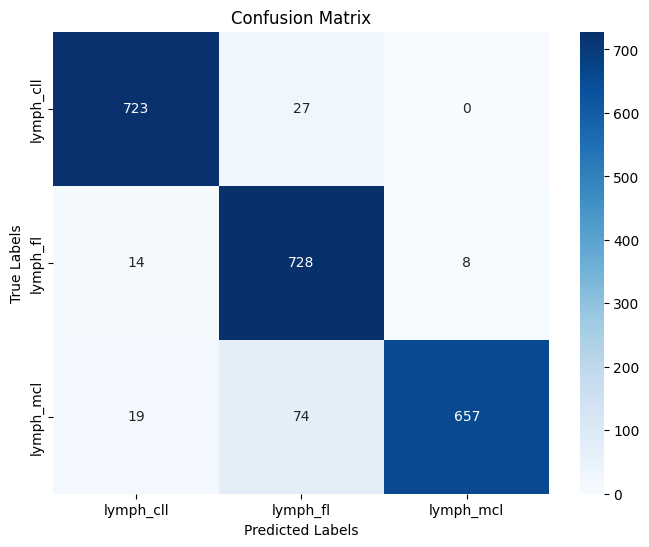

In [9]:
import seaborn as sns
def plot_confusion_matrix(conf_mat, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(conf_mat, class_names)

90/90 [==============================] - 44s 488ms/step


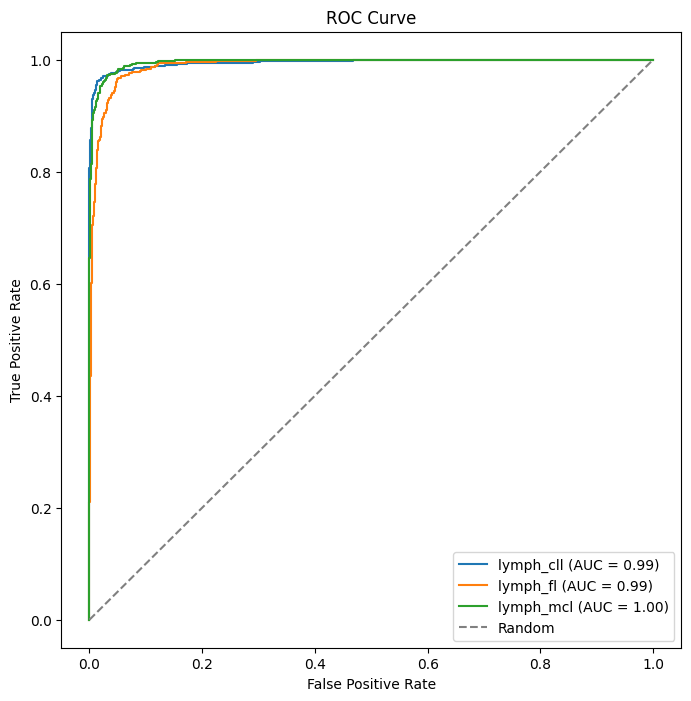

In [10]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, class_labels):
    plt.figure(figsize=(8, 8))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Get predicted probabilities for each class
y_prob = efficientnet_model.predict(test_ds)

# One-hot encode true labels
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))

# Plot ROC curve
plot_roc_curve(y_true_one_hot, y_prob, class_names)